In [13]:
#Imported the required lib files 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
import numpy as np

In [15]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))
data.head(5)

,text,sentiment
0,rt nancyleegrahn how did everyone feel about t...,Neutral
1,rt scottwalker didnt catch the full gopdebate ...,Positive
2,rt tjmshow no mention of tamir rice and the go...,Neutral
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive


In [16]:
#Here we are doing tokenization
tokenizer = Tokenizer(num_words=max_fatures, split=' ') #splitting the text  into tokens that we need 
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

X = pad_sequences(X)

embed_dim = 128
lstm_out = 196

In [17]:
#here below we add the model selected 

def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [18]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['sentiment'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [19]:
batch_size = 32
model = createmodel()
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2)
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print(score)
print(acc)
print(model.metrics_names)

291/291 - 45s - loss: 0.8217 - accuracy: 0.6466
144/144 - 3s - loss: 0.7617 - accuracy: 0.6758
0.7617255449295044
0.6758409738540649
['loss', 'accuracy']


In [23]:
#convert model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [25]:
# serialize weights to the selected mode;l
model.save_weights("model.h5")

In [26]:
#Here we Load the selected model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [27]:
# load the weights into the new selected  model
loaded_model.load_weights("model.h5")

In [28]:
#here we evaluate the model
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

accuracy: 71.02%


In [29]:
tweet = ['A lot of good things are happening. We are respected again throughout the world, and thats a great thing.@realDonaldTrump']

# here we are vectorizing the tweet by the pre-fitted tokenizer instance
tweet = tokenizer.texts_to_sequences(tweet)

In [30]:
# now we padding the tweet to have exactly the same shape as `embedding_2` input
tweet = pad_sequences(tweet, maxlen=28, dtype='int32', value=0)
print(tweet)
sentiment = model.predict(tweet, batch_size=1, verbose=2)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   8 439   6 144 290  36  31
   36 372   2 347   9 261   8 151 264  24]]
1/1 - 0s
[0.42514187 0.1693723  0.4054858 ]
negative


In [31]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=32)
# history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2,  callbacks=[tensorborad])
score,acc = model.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
from keras.models import load_model


Epoch 1/5
291/291 [==============================] - 50s 173ms/step - loss: 0.6823 - accuracy: 0.7070 - val_loss: 0.7402 - val_accuracy: 0.6796
Epoch 2/5
291/291 [==============================] - 50s 173ms/step - loss: 0.6146 - accuracy: 0.7437 - val_loss: 0.7545 - val_accuracy: 0.6861
Epoch 3/5
291/291 [==============================] - 50s 174ms/step - loss: 0.5728 - accuracy: 0.7629 - val_loss: 0.8036 - val_accuracy: 0.6649
Epoch 4/5
291/291 [==============================] - 50s 172ms/step - loss: 0.5240 - accuracy: 0.7834 - val_loss: 0.8422 - val_accuracy: 0.6643
Epoch 5/5
291/291 [==============================] - 50s 172ms/step - loss: 0.4789 - accuracy: 0.8049 - val_loss: 0.8973 - val_accuracy: 0.6734
144/144 - 3s - loss: 0.8973 - accuracy: 0.6734


In [37]:
# now we save the model.save('model.h5')
print("The percentage of the Score is " , score)
print("The percentage of the Accuracy is ", acc)

The percentage of the Score is  0.8973254561424255
The percentage of the Accuracy is  0.6734381914138794


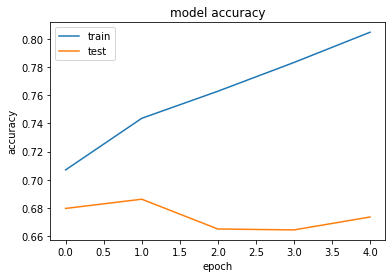

In [38]:
#here we find the loss and Accuracy
#accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


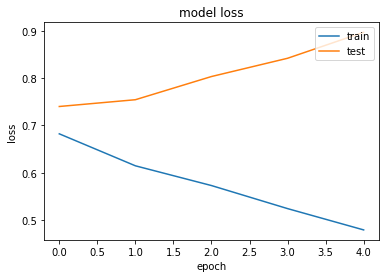

In [39]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [41]:
#Applying the GridSearchCV on the source code provided in the class
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model1 = KerasClassifier(build_fn=createmodel,verbose=0)
epochs = [1, 2]
param_grid= dict(epochs=epochs)
grid  = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1)
grid_result= grid.fit(X_train, Y_train,batch_size=32)
print("The Best percentage : %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.684494 using {'epochs': 2}
